Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## We are using the data by mounting the google drive, hence using the following :
from google.colab import drive
drive.mount("/content/drive/")
!ls
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive/
drive  sample_data


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Writting training dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  label_mode='categorical',
  class_names=None,
  color_mode='rgb',
  shuffle=True,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  interpolation='bilinear',
  follow_links=False,
  smart_resize=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [7]:
## Writing validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  label_mode='categorical',
  class_names=None,
  color_mode='rgb',
  shuffle=True,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  interpolation='bilinear',
  follow_links=False,
  smart_resize=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset

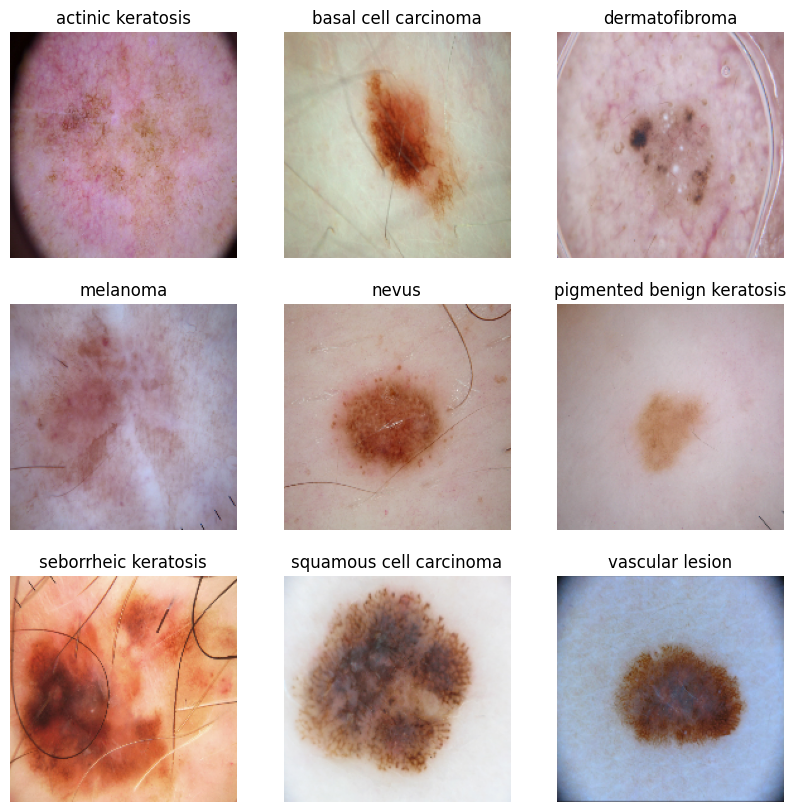

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model CNN1
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# Building CNN model with 9 classes , 2 convolutional units (convolutional layer + maxpool)
# and 1 fully connected layer and dropout layers in between
# for output softmax has been used
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),

  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 255s 1s/step - loss: 2.5816 - accuracy: 0.2161 - val_loss: 1.9550 - val_accuracy: 0.3964
Epoch 2/20
57/57 [==============================] - 3s 52ms/step - loss: 1.7284 - accuracy: 0.3978 - val_loss: 1.8582 - val_accuracy: 0.4744
Epoch 3/20
57/57 [==============================] - 3s 50ms/step - loss: 1.5608 - accuracy: 0.4683 - val_loss: 1.6427 - val_accuracy: 0.4788
Epoch 4/20
57/57 [==============================] - 3s 51ms/step - loss: 1.4596 - accuracy: 0.4961 - val_loss: 1.4539 - val_accuracy: 0.5100
Epoch 5/20
57/57 [==============================] - 3s 53ms/step - loss: 1.4627 - accuracy: 0.4983 - val_loss: 1.5182 - val_accuracy: 0.5033
Epoch 6/20
57/57 [==============================] - 3s 51ms/step - loss: 1.3429 - accuracy: 0.5400 - val_loss: 1.4484 - val_accuracy: 0.5145
Epoch 7/20
57/57 [==============================] - 3s 51ms/step - loss: 1.2949 - accuracy: 0.5583 - val_loss: 1.4377 - val_accuracy: 0.5167
Epoch 8/20
57

### Visualizing training results of CNN1

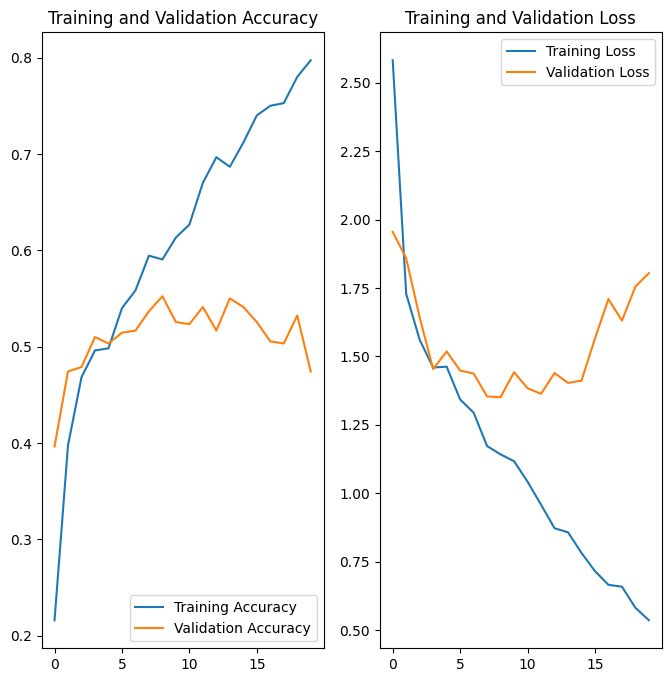

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings of Model CNN1 :

*   Training Loss: 0.5366
*   Validation Loss: 1.8044
*   Training Accuracy: 79.72%
*   Validation Accuracy: 47.44%

The training loss is relatively low, indicating that the model is fitting the training data well, with an accuracy of 79.72%.owever, there is a significant discrepancy between the training and validation performance. The validation loss is substantially higher, and the validation accuracy is lower (47.44%).

In [16]:
# After analysing the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

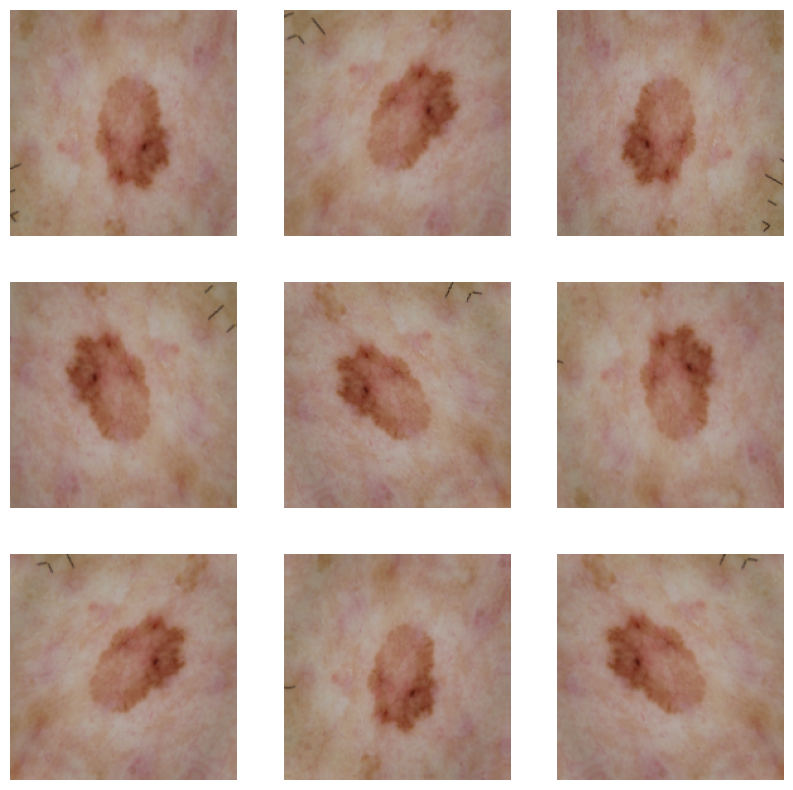

In [18]:
#visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Creating the model 2 : CNN2


In [19]:
# Now Building CNN model with 9 classes , 3 convolutional units (2 convolutional layer + 1 maxpool)
# and 1 fully connected layer and dropout layers in between
# for output softmax has been used

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.Conv2D(32,(3,3),activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.Conv2D(64,(3,3),activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.Conv2D(128,(3,3),activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])



### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 14s 136ms/step - loss: 2.2200 - accuracy: 0.1894 - val_loss: 2.0352 - val_accuracy: 0.1871
Epoch 2/20
57/57 [==============================] - 6s 113ms/step - loss: 2.0160 - accuracy: 0.1972 - val_loss: 1.9867 - val_accuracy: 0.2450
Epoch 3/20
57/57 [==============================] - 6s 113ms/step - loss: 1.9502 - accuracy: 0.2628 - val_loss: 1.8917 - val_accuracy: 0.2984
Epoch 4/20
57/57 [==============================] - 7s 115ms/step - loss: 1.8940 - accuracy: 0.2750 - val_loss: 1.8626 - val_accuracy: 0.3207
Epoch 5/20
57/57 [==============================] - 6s 112ms/step - loss: 1.8371 - accuracy: 0.3039 - val_loss: 1.7902 - val_accuracy: 0.3408
Epoch 6/20
57/57 [==============================] - 6s 114ms/step - loss: 1.7883 - accuracy: 0.3317 - val_loss: 1.6733 - val_accuracy: 0.3697
Epoch 7/20
57/57 [==============================] - 6s 114ms/step - loss: 1.6565 - accuracy: 0.3967 - val_loss: 1.6345 - val_accuracy: 0.4120
Epoch

### Visualizing the results of CNN2

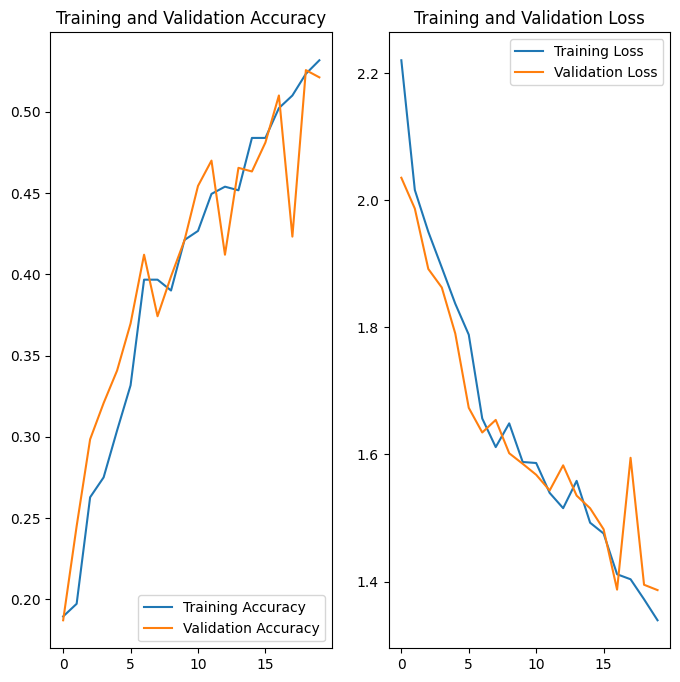

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings of Model CNN2:

*   Training Loss: 1.3391
*   Validation Loss: 1.3866
*   Training Accuracy: 53.17%
*   Validation Accuracy: 52.12%

The training loss is relatively high, indicating that the model is struggling to fit the training data, with an accuracy of 53.17%.The validation loss is similar to the training loss, and the validation accuracy is also not significantly higher (52.12%). To address this, you might want to consider adjusting your model architecture, hyperparameters, or increasing the size of your training dataset to improve the model's ability to capture the underlying patterns in the data.




#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2249

In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,drive/MyDrive/app/Skin cancer ISIC The Interna...,pigmented benign keratosis
1,drive/MyDrive/app/Skin cancer ISIC The Interna...,pigmented benign keratosis
2,drive/MyDrive/app/Skin cancer ISIC The Interna...,pigmented benign keratosis
3,drive/MyDrive/app/Skin cancer ISIC The Interna...,pigmented benign keratosis
4,drive/MyDrive/app/Skin cancer ISIC The Interna...,pigmented benign keratosis
...,...,...
2244,drive/MyDrive/app/Skin cancer ISIC The Interna...,seborrheic keratosis
2245,drive/MyDrive/app/Skin cancer ISIC The Interna...,seborrheic keratosis
2246,drive/MyDrive/app/Skin cancer ISIC The Interna...,seborrheic keratosis
2247,drive/MyDrive/app/Skin cancer ISIC The Interna...,seborrheic keratosis


## Visualize the class labels and their % distribution in the data

Class Labels= ['pigmented benign keratosis', 'melanoma', 'vascular lesion', 'squamous cell carcinoma', 'actinic keratosis', 'basal cell carcinoma', 'nevus', 'dermatofibroma', 'seborrheic keratosis']
Class=5, n=462 (20.542%)
Class=3, n=438 (19.475%)
Class=8, n=149 (6.625%)
Class=7, n=181 (8.048%)
Class=0, n=114 (5.069%)
Class=1, n=376 (16.719%)
Class=4, n=357 (15.874%)
Class=2, n=95 (4.224%)
Class=6, n=77 (3.424%)


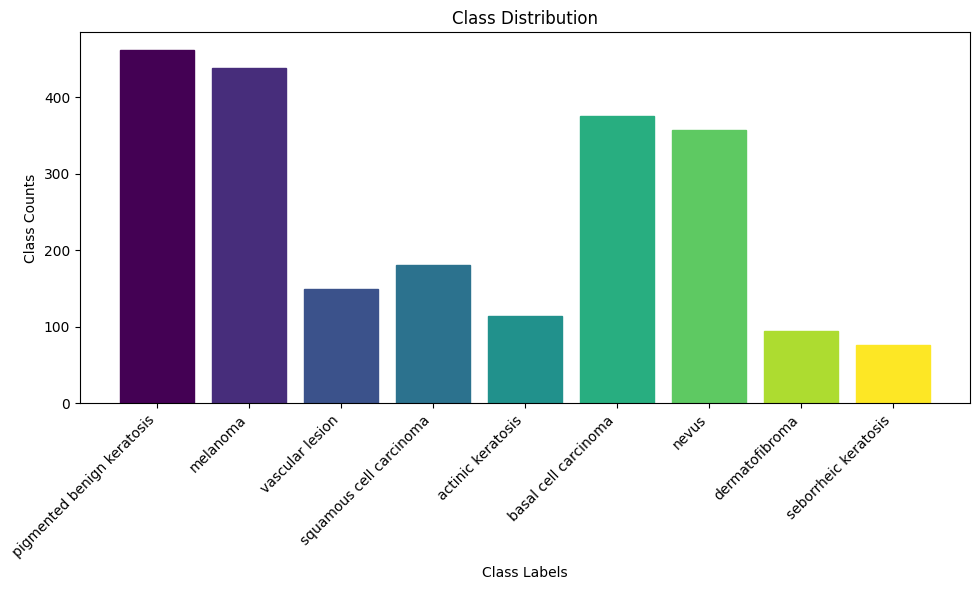

In [25]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
label_encoder=LabelEncoder()
y = label_encoder.fit_transform(y)
# summarize distribution
counter = Counter(y)
# Get the mapping from encoded labels to original labels
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

class_labels = [label_mapping[label] for label in counter.keys()]
class_counts = list(counter.values())
print("Class Labels=",class_labels)

# Define colors for each unique label
labels = label_encoder.classes_
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, class_counts)
for i, bar in enumerate(bars):
    bar.set_color(colors[i])
plt.xlabel('Class Labels')
plt.ylabel('Class Counts')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Findings are here:
#### - Which class has the least number of samples?
seborrheic keratosis has least number of samples- 77
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis is dominating the the data in terms proportionate number of samples - 462

#### Class Imbalance Detected: We'll use data augmentation to balance the class distribution.
### Data augmentation helps generate additional training samples for underrepresented classes.



#### We need to Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8C2C403C40>: 100%|██████████| 500/500 [00:18<00:00, 27.67 Samples/s]


Initialised with 376 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8C2C3ABD90>: 100%|██████████| 500/500 [00:22<00:00, 22.38 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8C2C2CC250>: 100%|██████████| 500/500 [00:23<00:00, 21.35 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8C2C1ED660>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]


Initialised with 357 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F8C2C42E050>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8C2C343A30>: 100%|██████████| 500/500 [00:22<00:00, 21.76 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8CC81527A0>: 100%|██████████| 500/500 [00:37<00:00, 13.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8C2C31E080>: 100%|██████████| 500/500 [00:17<00:00, 27.91 Samples/s]


Initialised with 149 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8C2C341420>: 100%|██████████| 500/500 [00:17<00:00, 28.91 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027737.jpg_0fe311ed-9ac7-4a32-bb5c-87f964851102.jpg',
 'drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025434.jpg_478d06a9-971f-4c51-a8ae-ead9bd384c36.jpg',
 'drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026871.jpg_ffeaf31c-72be-4dce-93e8-9627e80ede51.jpg',
 'drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025063.jpg_ad0651a4-f4b3-416b-9ca6-834d011d058b.jpg',
 'drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmen

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [31]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-32-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [33]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               649
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [45]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### Creating model (make sure to include normalization) CNN3

In [37]:
# Now Building CNN model with 9 classes , 2 convolutional units (convolutional layer + 1 maxpool)
# and 2 fully connected layer and dropout layers in between
# for output softmax has been used
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dropout(0.5),

  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),

  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),

  layers.Dense(num_classes,activation='softmax')
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [38]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

####  Train your model

In [39]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 83ms/step - loss: 2.1335 - accuracy: 0.2107 - val_loss: 1.7253 - val_accuracy: 0.3855
Epoch 2/30
169/169 [==============================] - 5s 31ms/step - loss: 1.7835 - accuracy: 0.3207 - val_loss: 1.5730 - val_accuracy: 0.4077
Epoch 3/30
169/169 [==============================] - 5s 32ms/step - loss: 1.6537 - accuracy: 0.3652 - val_loss: 1.4630 - val_accuracy: 0.4359
Epoch 4/30
169/169 [==============================] - 6s 33ms/step - loss: 1.5323 - accuracy: 0.4111 - val_loss: 1.5589 - val_accuracy: 0.4070
Epoch 5/30
169/169 [==============================] - 5s 32ms/step - loss: 1.4916 - accuracy: 0.4217 - val_loss: 1.3517 - val_accuracy: 0.4611
Epoch 6/30
169/169 [==============================] - 5s 31ms/step - loss: 1.4181 - accuracy: 0.4496 - val_loss: 1.2728 - val_accuracy: 0.5234
Epoch 7/30
169/169 [==============================] - 5s 31ms/step - loss: 1.3486 - accuracy: 0.4759 - val_loss: 1.1990 - val_accuracy: 0.538

#### Visualize the model results of CNN3

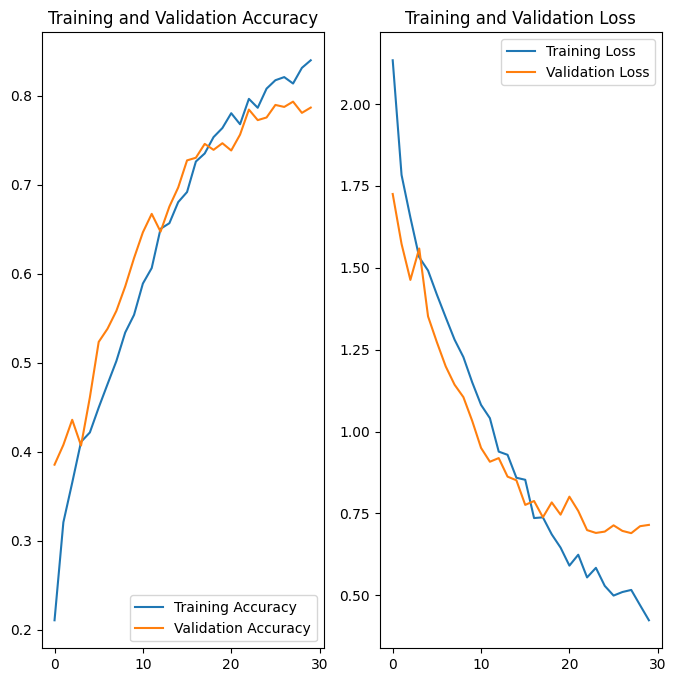

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Creating Model CNN4

In [41]:
# Now Building CNN model with 9 classes , 3 convolutional units (convolutional layer + 1 maxpool)
# and 2 fully connected layer and dropout layers in between
# for output softmax has been used
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dropout(0.5),

  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),

  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),

  layers.Dense(num_classes,activation='softmax')
])

In [42]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train Model CNN4

In [43]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 7s 26ms/step - loss: 2.1160 - accuracy: 0.1930 - val_loss: 1.7986 - val_accuracy: 0.3454
Epoch 2/30
169/169 [==============================] - 4s 23ms/step - loss: 1.7093 - accuracy: 0.3435 - val_loss: 1.5159 - val_accuracy: 0.4151
Epoch 3/30
169/169 [==============================] - 4s 22ms/step - loss: 1.5741 - accuracy: 0.3889 - val_loss: 1.4441 - val_accuracy: 0.4381
Epoch 4/30
169/169 [==============================] - 4s 24ms/step - loss: 1.4332 - accuracy: 0.4500 - val_loss: 1.3451 - val_accuracy: 0.4789
Epoch 5/30
169/169 [==============================] - 4s 23ms/step - loss: 1.3884 - accuracy: 0.4652 - val_loss: 1.2467 - val_accuracy: 0.5189
Epoch 6/30
169/169 [==============================] - 4s 22ms/step - loss: 1.2709 - accuracy: 0.5113 - val_loss: 1.1060 - val_accuracy: 0.5745
Epoch 7/30
169/169 [==============================] - 4s 22ms/step - loss: 1.1962 - accuracy: 0.5433 - val_loss: 1.0626 - val_accuracy: 0.6086

## Visualize Model CNN4

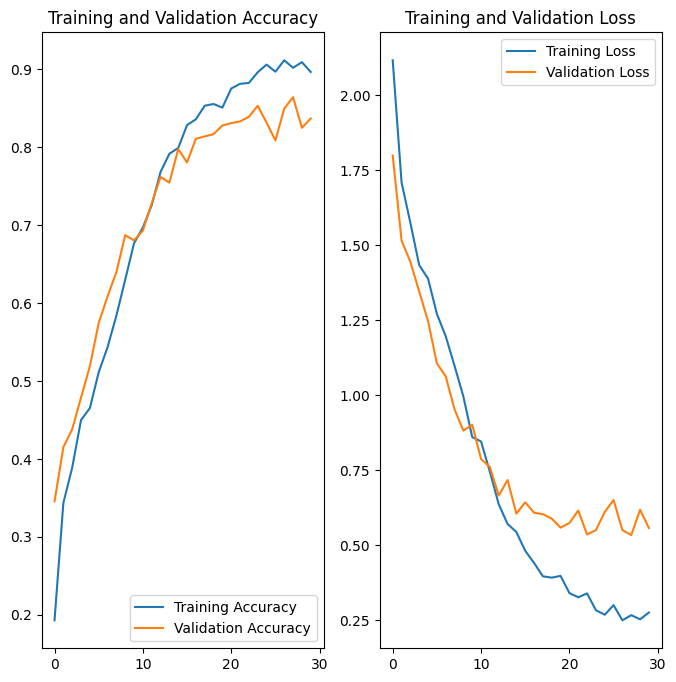

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings of Model CNN4:

*   Training Loss: 0.2754
*   Validation Loss: 0.5571
*   Training Accuracy: 89.67%
*   Validation Accuracy: 83.69%

* Linear trend in both training and validation accuracy throughout the training process.
* As the number of training epochs increases, both training and validation accuracies exhibit consistent improvement.

*   The training loss is relatively low, indicating that the model is fitting the training data very well, with an accuracy of 89.67%.
*   The validation loss is higher than the training loss, but the validation accuracy is still relatively high (83.69%).

Overall, these results suggest that the model is performing well and has a good balance between fitting the training data and generalizing to the validation data.

